# Analyzing the correlation matrices

## Reading the data

In [1]:
%pylab inline
from __future__ import print_function, division

import os
import os.path as osp
import matplotlib.pyplot as plt

from warnings import warn
import datetime, time
import glob as gb
from six import string_types
import argparse
import json

import numpy as np
import scipy.linalg as lin
import scipy.stats as sst

import nibabel as nib
import nipy
from nilearn._utils import concat_niimgs


Populating the interactive namespace from numpy and matplotlib


In [2]:
param_dir = osp.abspath('.')
assert param_dir == '/home/jb/code/simpace/simpace'

In [3]:
import importlib
from smpce_data_to_corr import get_params
import utils._utils as ucr
import utils.setup_filenames as suf
#import tests.test_smpce_data_to_corr as tts

ucr = reload(ucr)
suf = reload(suf)

In [4]:
params = get_params(param_dir)
basedir = '/home/jb/data/simpace/data/rename_files'

In [5]:
djdata = params['data']
djlayo = params['layout']

nb_sess = params['data']['nb_sess']
nb_sub = params['data']['nb_sub']
nb_run = params['data']['nb_run']
print(nb_sub, nb_sess, nb_run)

1 11 4


In [6]:
def _get_signals_filenames(basedir, params):
    
    layo = params['layout']
    nb_sess = params['data']['nb_sess']
    nb_sub = params['data']['nb_sub']
    nb_run = params['data']['nb_run']
    druns = layo['dir']['runs']
    dsig = layo['dir']['signals']
    
    conditions = ['none', 'low', 'med', 'high']
    conds = {}
    conds_pat = ['*NONE.npz', '*LOW.npz', '*MED.npz', '*HIGH.npz']
    for c in conditions:
        conds[c] = []

    sessions = range(1,nb_sess+1)

    for sess in sessions:
        sesstr = 'sess{:02d}'.format(sess)
        fulldsig = osp.join(basedir, 'sub01', sesstr, druns, dsig)
        for idx, c in enumerate(conditions):
            conds[c].append(gb.glob(osp.join(fulldsig, conds_pat[idx]))[0])
        
    # some basic checks: all the same length
    assert not np.any( np.diff(np.asarray([len(conds[c]) for c in conditions])) )
    
    return conds

In [41]:
conds = _get_signals_filenames(basedir, params)
print(conds.keys())

['high', 'med', 'none', 'low']


In [42]:
def ordered_conds():
    return ['none', 'low', 'med', 'high']

### Get the common list of labels:

In [20]:
def _get_common_labels(conds, idx0=0):
    
    cond0 = conds.keys()[idx0] 
    nb_sess = len(conds[cond0])
    
    lsets = []
    for sess in range(nb_sess):
        lsets.append( set((np.load(conds[cond0][sess]))['labels_sig']) )

    return set.intersection(*lsets)

In [27]:
common_labels = _get_common_labels(conds)
assert common_labels == _get_common_labels(conds, idx0=3)

In [28]:
tmp = np.load(conds['med'][7])
tmp.keys()

['info',
 'arr_counf',
 'labels_sig',
 'arr_sig',
 'labs_counf',
 'params',
 'arr_sig_f',
 'issues']

In [79]:
tmp['labels_sig'].shape
tmp['arr_sig_f'].shape

(196, 102)

In [35]:

def compute_corr_mtx(conds, common_labels):
    """
    returns
    -------
    arr: list of 4 np.array, each (nsess, common_len, common_len)
    """
    idx0 = 0
    conditions = conds.keys()
    cond0 = conditions[idx0] 
    nb_sess = len(conds[cond0])
    nb_cond = len(conds)
    shape_c = (nb_sess, len(common_labels), len(common_labels))
    
    conds_arr = {}
    
    for cond in conditions:
        arr_c = np.empty(shape_c)
        arr_c.fill(10.)
        
        for sess in range(nb_sess):
            dctsig = np.load(conds[cond][sess])
            idx_lab = np.asarray([lab in common_labels for lab in dctsig['labels_sig']])
            com_lab = [lab for lab in dctsig['labels_sig'] if lab in common_labels]
            assert idx_lab.sum() == len(common_labels), "{},{}".format(
                                idx_lab.shape[0] ,len(common_labels))
            arr_c[sess] = np.corrcoef(dctsig['arr_sig_f'][:,idx_lab].T)

        conds_arr[cond] = arr_c
        conds_arr['labels'] = com_lab

    return conds_arr

In [36]:
conds_arr = compute_corr_mtx(conds, common_labels)

In [43]:
print(conds_arr.keys())
print(conds_arr['high'].shape)
for cond in ordered_conds(): # [none_c, low_c, med_c, high_c]:
    assert np.all(conds_arr[cond] <= 1.) and np.all(conds_arr[cond] >= -1.) 

['high', 'med', 'none', 'labels', 'low']
(11, 94, 94)


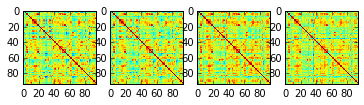

In [44]:
f, axes = plt.subplots(1, 4)
arr = [conds_arr[c] for c in ordered_conds()]

for idx, ax in enumerate(axes): 
    ax.imshow(arr[idx].mean(axis=0), aspect='equal', interpolation='nearest', 
              vmin=-.5, vmax=1.)

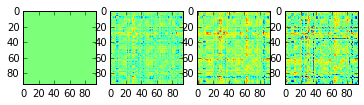

In [45]:
f, axes = plt.subplots(1, 4)
arr = [conds_arr[c] for c in ordered_conds()]

for idx, ax in enumerate(axes): 
    ax.imshow(arr[idx].mean(axis=0) - arr[0].mean(axis=0), 
              aspect='equal', interpolation='nearest',
              vmin=-.5, vmax=.5)

In [46]:
a0 = conds_arr['none'].mean(axis=0)
for idx, a in enumerate(arr):
    print((a.mean(axis=0) - a0).min(), (a.mean(axis=0) - a0).max()) 

0.0 0.0
-0.348006890313 0.336821419905
-0.503448631545 0.414455364305
-0.712603931487 0.393459900329


In [110]:
np.tril(np.arange(5*5).reshape(5,5))

array([[ 0,  0,  0,  0,  0],
       [ 5,  6,  0,  0,  0],
       [10, 11, 12,  0,  0],
       [15, 16, 17, 18,  0],
       [20, 21, 22, 23, 24]])

In [114]:
itriu = np.triu_indices(5)

In [115]:
np.arange(5*5).reshape(5,5)[itriu]

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 12, 13, 14, 18, 19, 24])